## Ensemble Controller
Testing projected A-clamp with ensembling to see if we can get further improvement on the control

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision.models as models
from util.EnsembleModelController import EnsembleController
from util.misc_functions import float2rgb
from dataset.hvm import HVMDataset
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
# load up target and source models
squeezenet1 = models.squeezenet1_1(pretrained=True).features
squeezenet0 = models.squeezenet1_0(pretrained=True).features
alexnet = models.alexnet(pretrained=True).features
vgg16 = models.vgg16(pretrained=True).features
resnet = torch.nn.Sequential(*list(models.resnet18(pretrained=True).children()))
densenet = models.densenet161(pretrained=True).features
inception = torch.nn.Sequential(*list(models.inception_v3(pretrained=True).children())[:-3])
mobilenet = models.mobilenet_v2(pretrained=True).features
googlenet = torch.nn.Sequential(*list(models.googlenet(pretrained=True).children())[:-3])

In [3]:
# package as input to the controller
nets = [inception,googlenet,mobilenet,squeezenet1,squeezenet0,vgg16,resnet,densenet,alexnet]
labels = ['inception','googlenet','mobilenet','squeeze1_1','squeeze1_0','vgg16','resnet18','densenet','alexnet']
layers = [11,16,19,13,13,30,8,18,13]
n_models = len(labels)

In [4]:
# load dataset
n_data = 5500;
n_train = 4000;
n_test = 1500;
n_targets = 200;
hvmdataset = HVMDataset('cpu',n_data, shuffle = True)

loading and preprocessing hvm


100%|█████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:22<00:00, 247.77it/s]


In [5]:
n_clamp = 500;
hvmclampset = HVMDataset('cpu', n_data, n_train, n_test, n_clamp, shuffle = True, subset = 'clamp')

loading and preprocessing hvm


100%|████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:01<00:00, 3277.16it/s]


In [6]:
# create ensemble controller
EC1 = EnsembleController(nets,layers,labels,device)

In [7]:
EC1.design(hvmdataset, batch_size = 10)
EC1.train_test_subset(n_train,n_test,n_targets)

Extracting activations


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:23<00:00, 24.54s/it]


In [8]:
EC1.fit(option = 'TR', label = '8_121820', n_iter = 100, w_reg = 10, load = True)

Mapping inception --> alexnet


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [11:24<00:00,  3.71s/it]


Mapping googlenet --> alexnet


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [12:23<00:00,  2.93s/it]


Mapping mobilenet --> alexnet


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [14:36<00:00,  3.18s/it]


Mapping squeeze1_1 --> alexnet


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [11:22<00:00,  3.65s/it]


Mapping squeeze1_0 --> alexnet


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [12:27<00:00,  4.86s/it]


Mapping vgg16 --> alexnet


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [16:46<00:00,  6.16s/it]


Mapping resnet18 --> alexnet


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:50<00:00,  2.38s/it]


Mapping densenet --> alexnet


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [26:45<00:00,  7.08s/it]


Mapping alexnet --> alexnet


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:31<00:00,  2.06it/s]


In [9]:
EC1.score_models()
EC1.get_surrogate()
EC1.score_ensembles()

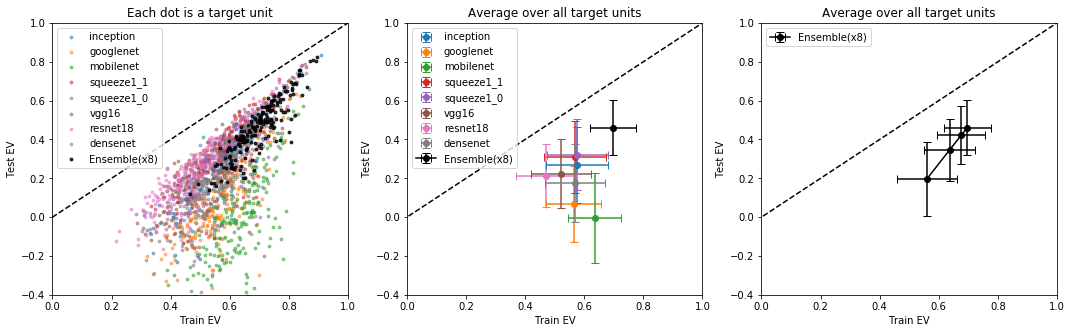

In [19]:
plt.figure(figsize=(18,5))
ax1 = plt.subplot(1,3,1)
for n in range(EC1.n_models-1):
    plt.scatter(EC1.models[n]['train_score'],EC1.models[n]['test_score'],label = EC1.models[n]['id'],alpha = .5,s=8)
plt.scatter(EC1.ensemble['train_score'][:,0,-1],EC1.ensemble['test_score'][:,0,-1],label=f'Ensemble(x{n_models-1})',c='k',alpha = .8, s=8)
plt.plot([-1,1],[-1,1],'k--')
plt.xlabel('Train EV')
plt.ylabel('Test EV')
plt.title('Each dot is a target unit')
plt.legend()
plt.xlim([0,1])
plt.ylim([-.4,1])
ax2 = plt.subplot(1,3,2)
for n in range(EC1.n_models-1):
    plt.errorbar(np.mean(EC1.models[n]['train_score']), np.mean(EC1.models[n]['test_score']), xerr=np.std(EC1.models[n]['train_score']), yerr=np.std(EC1.models[n]['test_score']), fmt='o',capsize=4, label = EC1.models[n]['id'])
plt.errorbar(np.mean(EC1.ensemble['train_score'][:,0,-1],axis = 0),np.mean(EC1.ensemble['test_score'][:,0,-1],axis = 0), xerr=np.std(EC1.ensemble['train_score'][:,0,-1],axis = 0), yerr=np.std(EC1.ensemble['test_score'][:,0,-1],axis = 0), fmt='ko-',capsize=4,label=f'Ensemble(x{n_models-1})')
plt.plot([-1,1],[-1,1],'k--')
plt.title('Average over all target units')
plt.xlabel('Train EV')
plt.ylabel('Test EV')
plt.legend()
plt.xlim([0,1])
plt.ylim([-.4,1])
ax2 = plt.subplot(1,3,3)
plt.errorbar(np.mean(np.mean(EC1.ensemble['train_score'][:,:,[0,1,3,7]],axis = 0),axis=0),np.mean(np.mean(EC1.ensemble['test_score'][:,:,[0,1,3,7]],axis = 0),axis=0), xerr=np.mean(np.std(EC1.ensemble['train_score'][:,:,[0,1,3,7]],axis = 0),axis = 0), yerr=np.mean(np.std(EC1.ensemble['test_score'][:,:,[0,1,3,7]],axis = 0),axis=0), fmt='ko-',capsize=4,label=f'Ensemble(x{n_models-1})')
plt.plot([-1,1],[-1,1],'k--')
plt.title('Average over all target units')
plt.xlabel('Train EV')
plt.ylabel('Test EV')
plt.legend()
plt.xlim([0,1])
plt.ylim([-.4,1])
plt.show()

In [11]:
# projected A-clamp with indivisual models and with ensemble
EC1.design_proj_clamp(hvmclampset, epsilon = 10, n_sets = 20, set_size = 40)

In [12]:
# load saved experiments
paramdic = torch.load('params\\ModelPClamps_eps10.pt')
EC1.clamp_set_i = paramdic['clamp_set_i']
EC1.clamp_set_idx = paramdic['clamp_set_idx']
EC1.ensemble['sur_p_eps'] = paramdic['sur_p_eps'][0]/10*5
EC1.ensemble['sur_p_vec'] = paramdic['sur_p_vec'][0]
EC1.ensemble['sur_p_obs'] = paramdic['sur_ep_obs']
EC1.ensemble['tar_p_obs'] = paramdic['tar_ep_obs']
EC1.ensemble['ep_dx'] = paramdic['ep_dx']

for n in range(EC1.n_models-1):
    EC1.models[n]['sur_p_eps']  = paramdic['sur_p_eps'][n]/10*5
    EC1.models[n]['sur_p_vec']  = paramdic['sur_p_vec'][n]
    EC1.models[n]['sur_p_obs']  = paramdic['sur_mp_obs'][n]
    EC1.models[n]['tar_p_obs']  = paramdic['tar_mp_obs'][n]
    EC1.models[n]['p_dx'] = paramdic['mp_dx'][n]

In [12]:
EC1.proj_ensemble_clamp(hvmclampset, lr = .01, wd = 1e-3, n_iter = 10, batch_size = 2)

Projected A-Clamping with ensemble(x8)


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [4:09:14<00:00, 58.97s/it]


In [13]:
EC1.proj_model_clamp(lr = .01, wd = 1e-3, n_iter = 10)

Projected A-Clamping inception --> alexnet


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [16:44<00:00,  4.01s/it]


Projected A-Clamping googlenet --> alexnet


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [25:44<00:00,  6.94s/it]


Projected A-Clamping mobilenet --> alexnet


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [22:13<00:00,  5.36s/it]


Projected A-Clamping squeeze1_1 --> alexnet


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [13:38<00:00,  3.28s/it]


Projected A-Clamping squeeze1_0 --> alexnet


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [14:03<00:00,  3.31s/it]


Projected A-Clamping vgg16 --> alexnet


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [45:50<00:00, 11.00s/it]


Projected A-Clamping resnet18 --> alexnet


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [29:38<00:00,  7.11s/it]


Projected A-Clamping densenet --> alexnet


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [1:21:17<00:00, 19.76s/it]


Projected A-Clamping alexnet --> alexnet


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [05:29<00:00,  1.31s/it]


In [16]:
EC1.proj_clamp_score()

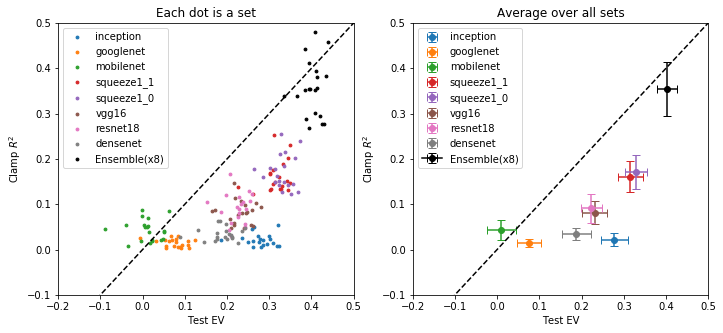

In [17]:
plt.figure(figsize=(18,5))
ax1 = plt.subplot(1,3,1)
for n in range(EC1.n_models-1):
    set_test_score = np.zeros(EC1.n_sets)
    for s in range(EC1.n_sets):
        set_test_score[s] = EC1.models[n]['test_score'][EC1.clamp_set_i[:,s]].mean()
    plt.scatter(set_test_score,EC1.models[n]['ctr_p_score']**2,label = EC1.models[n]['id'],s=8)
set_test_escore = np.zeros(EC1.n_sets)
for s in range(EC1.n_sets):
    set_test_escore[s] = EC1.ensemble['test_score'][EC1.clamp_set_i[:,s]].mean()    
plt.scatter(set_test_escore,EC1.ensemble['ctr_p_score']**2,label=f'Ensemble(x{n_models-1})',c='k',s=8)
plt.plot([-1,1],[-1,1],'k--')
plt.xlabel('Test EV')
plt.ylabel(r'Clamp $R^2$')
plt.title('Each dot is a set')
plt.legend()
plt.xlim([-.2,.5])
plt.ylim([-.1, .5])

ax2 = plt.subplot(1,3,2)
for n in range(EC1.n_models-1):
    set_test_score = np.zeros(EC1.n_sets)
    for s in range(EC1.n_sets):
        set_test_score[s] = EC1.models[n]['test_score'][EC1.clamp_set_i[:,s]].mean()
    plt.errorbar(np.mean(set_test_score), np.mean(EC1.models[n]['ctr_p_score']**2), xerr=np.std(set_test_score), yerr=np.std(EC1.models[n]['ctr_p_score']**2), fmt='o',capsize=4, label = EC1.models[n]['id'])
plt.errorbar(np.mean(set_test_escore,axis = 0), np.mean(EC1.ensemble['ctr_p_score']**2,axis = 0), xerr=np.std(set_test_escore,axis = 0), yerr=np.std(EC1.ensemble['ctr_p_score']**2,axis = 0), fmt='ko-',capsize=4,label=f'Ensemble(x{n_models-1})')
plt.plot([-1,1],[-1,1],'k--')
plt.title('Average over all sets')
plt.xlabel('Test EV')
plt.ylabel(r'Clamp $R^2$')
plt.legend()
plt.xlim([-.2,.5])
plt.ylim([-.1, .5])
plt.show()

In [26]:
# saving ensemble and model proj A-clamp results
sur_p_eps = torch.zeros((EC1.n_models-1,EC1.n_clamp_img,EC1.n_sets), requires_grad = False)
sur_p_vec = torch.zeros((EC1.n_models-1,EC1.set_size,EC1.n_sets), requires_grad = False)
sur_mp_obs = torch.zeros((EC1.n_models-1,EC1.n_clamp_img,EC1.n_sets), requires_grad = False)
tar_mp_obs = torch.zeros((EC1.n_models-1,EC1.n_clamp_img,EC1.n_sets), requires_grad = False)
mp_dx = torch.zeros((EC1.n_models-1,EC1.n_clamp_img,EC1.n_sets), requires_grad = False)

sur_ep_obs = EC1.ensemble['sur_p_obs']
tar_ep_obs = EC1.ensemble['tar_p_obs']
ep_dx = EC1.ensemble['p_dx']

for n in range(EC1.n_models-1):
    sur_p_eps[n] = EC1.models[n]['sur_p_eps'] 
    sur_p_vec[n] = EC1.models[n]['sur_p_vec'] 
    sur_mp_obs[n] = EC1.models[n]['sur_p_obs'] 
    tar_mp_obs[n] = EC1.models[n]['tar_p_obs'] 
    mp_dx[n] = EC1.models[n]['p_dx']
    
paramdict = {'clamp_set_i': EC1.clamp_set_i, 'clamp_set_idx': EC1.clamp_set_idx,'sur_p_eps': sur_p_eps , 'sur_p_vec': sur_p_vec,'sur_mp_obs': sur_mp_obs , 'tar_mp_obs': tar_mp_obs, 'mp_dx': mp_dx,'sur_ep_obs': sur_ep_obs , 'tar_ep_obs': tar_ep_obs, 'ep_dx': ep_dx}
torch.save(paramdict,'params\\ModelPClamps100.pt')

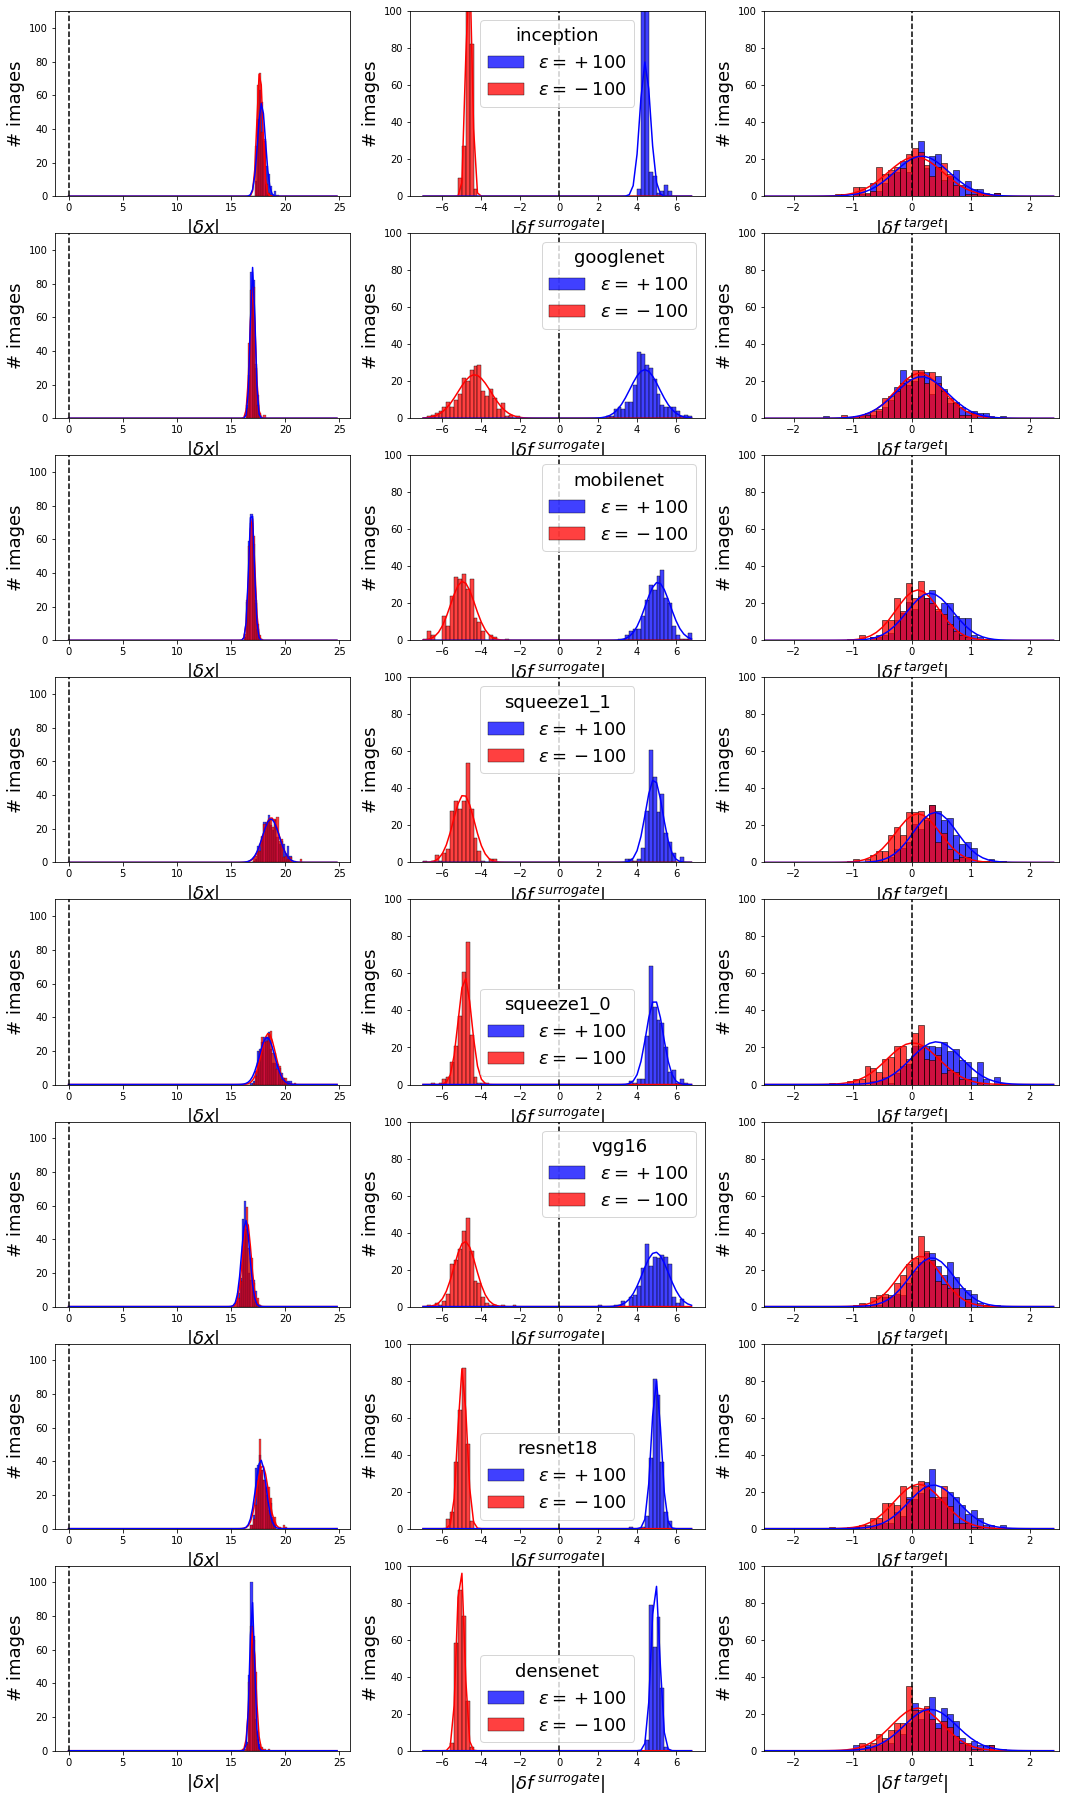

In [35]:
import seaborn as sns

gaussfit = lambda x,mu,sig: 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)
eps = 5
mad = lambda x: np.median(abs(x-np.median(x)))

samp_set = np.argmax(EC1.ensemble['ctr_p_score'])
plt.figure(figsize=(18,4*(EC1.n_models-1)))
for n in range(EC1.n_models-1):
    # show example of single neuron activity clamp
    pidx = EC1.models[n]['sur_p_eps'][:,samp_set]>2
    nidx = EC1.models[n]['sur_p_eps'][:,samp_set]<-1
    p_sur_obs = EC1.models[n]['sur_p_obs'].numpy()[pidx,samp_set]
    n_sur_obs = EC1.models[n]['sur_p_obs'].numpy()[nidx,samp_set]
    plt.subplot(EC1.n_models-1,3,2+n*3)
    xdelta = .2
    xbin = np.arange(-eps-2,eps+2,xdelta)
    sns.histplot(p_sur_obs,bins = xbin,color='b',label=r'$\epsilon = +100$')
    sns.histplot(n_sur_obs,bins = xbin,color='r',label=r'$\epsilon = -100$')
    plt.plot(xbin, gaussfit(xbin,np.median(n_sur_obs),np.std(n_sur_obs))*len(p_sur_obs)*xdelta,'r-')
    plt.plot(xbin, gaussfit(xbin,np.median(p_sur_obs),np.std(p_sur_obs))*len(p_sur_obs)*xdelta,'b-')
    plt.plot([0,0],[0,1000],'k--')
    plt.ylim((0,n_clamp/5))
    plt.xlabel(r'$|\delta f^{\ surrogate}|$',fontsize = 18)
    plt.ylabel(r'# images',fontsize = 18)
    legend = plt.legend(fontsize = 18, title=EC1.models[n]['id'])
    legend.get_title().set_fontsize('18')
    
    p_tar_obs = EC1.models[n]['tar_p_obs'].numpy()[pidx,samp_set]
    n_tar_obs = EC1.models[n]['tar_p_obs'].numpy()[nidx,samp_set]
    plt.subplot(EC1.n_models-1,3,3+n*3)
    xdelta3 = .1
    xbin3 = np.arange(-eps/2,eps/2,xdelta3)
    sns.histplot(p_tar_obs,bins = xbin3,color='b',label=r'$\epsilon = +100$')
    sns.histplot(n_tar_obs,bins = xbin3,color='r',label=r'$\epsilon = -100$')
    plt.plot(xbin3, gaussfit(xbin3,np.median(n_tar_obs),np.std(n_tar_obs))*len(p_sur_obs)*xdelta3,'r-')
    plt.plot(xbin3, gaussfit(xbin3,np.median(p_tar_obs),np.std(p_tar_obs))*len(p_sur_obs)*xdelta3,'b-')
    plt.plot([0,0],[0,1000],'k--')
    plt.ylim((0,n_clamp/10))
    plt.xlim([-eps/2, eps/2])
    plt.xlabel(r'$|\delta f^{\ target}|$',fontsize = 18)
    plt.ylabel(r'# images',fontsize = 18)

    p_dx = EC1.models[n]['p_dx'].numpy()[pidx,samp_set]
    n_dx = EC1.models[n]['p_dx'].numpy()[nidx,samp_set]
    plt.subplot(EC1.n_models-1,3,1+n*3)
    xdelta1 = .2
    xbin1 = np.arange(0,eps*5,xdelta1)
    sns.histplot(p_dx,bins = xbin1,color='b',label=r'$\epsilon = +100$')
    sns.histplot(n_dx,bins = xbin1,color='r',label=r'$\epsilon = -100$')
    plt.plot(xbin1, gaussfit(xbin1,np.median(n_dx),np.std(n_dx))*len(p_sur_obs)*xdelta1,'r-')
    plt.plot(xbin1, gaussfit(xbin1,np.median(p_dx),np.std(p_dx))*len(p_sur_obs)*xdelta1,'b-')
    plt.plot([0,0],[0,1000],'k--')
    plt.ylim((0,n_data/50))
    plt.xlabel(r'$|\delta x|$',fontsize = 18)
    plt.ylabel(r'# images',fontsize = 18)
plt.show()

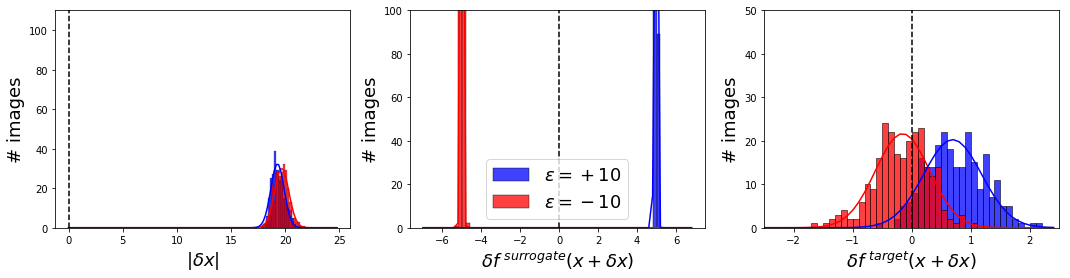

In [39]:
# show example of single neuron activity clamp
plt.figure(figsize=(18,4))
pidx = EC1.ensemble['sur_p_eps'][:,samp_set]>0
nidx = EC1.ensemble['sur_p_eps'][:,samp_set]<0
p_sur_obs = EC1.ensemble['sur_p_obs'].numpy()[pidx,samp_set]
n_sur_obs = EC1.ensemble['sur_p_obs'].numpy()[nidx,samp_set]
ax1 = plt.subplot(1,3,2)
sns.histplot(p_sur_obs,bins = xbin,color='b',label=r'$\epsilon = +10$')
sns.histplot(n_sur_obs,bins = xbin,color='r',label=r'$\epsilon = -10$')
plt.plot(xbin, gaussfit(xbin,np.median(n_sur_obs),mad(n_sur_obs))*len(p_sur_obs)*xdelta,'r-')
plt.plot(xbin, gaussfit(xbin,np.median(p_sur_obs),mad(p_sur_obs))*len(p_sur_obs)*xdelta,'b-')
plt.plot([0,0],[0,1000],'k--')
plt.axis('tight')
plt.ylim((0,n_clamp/5))
plt.xlabel(r'$\delta f^{\ surrogate}(x+\delta x)$',fontsize = 18)
plt.ylabel(r'# images',fontsize = 18)
plt.legend(fontsize = 18)

p_tar_obs = EC1.ensemble['tar_p_obs'].numpy()[pidx,samp_set]
n_tar_obs = EC1.ensemble['tar_p_obs'].numpy()[nidx,samp_set]
ax2 = plt.subplot(1,3,3)
sns.histplot(p_tar_obs,bins = xbin3,color='b',label=r'$\epsilon = +10$')
sns.histplot(n_tar_obs,bins = xbin3,color='r',label=r'$\epsilon = -10$')
plt.plot(xbin3, gaussfit(xbin3,np.median(n_tar_obs),np.std(n_tar_obs))*len(p_sur_obs)*xdelta3,'r-')
plt.plot(xbin3, gaussfit(xbin3,np.median(p_tar_obs),np.std(p_tar_obs))*len(p_sur_obs)*xdelta3,'b-')
plt.plot([0,0],[0,1000],'k--')
plt.axis('tight')
plt.axis('tight')
plt.ylim((0,n_clamp/10))
plt.xlim([-eps/2, eps/2])
plt.xlabel(r'$\delta f^{\ target}(x+\delta x)$',fontsize = 18)
plt.ylabel(r'# images',fontsize = 18)

p_dx = EC1.ensemble['p_dx'].numpy()[pidx,samp_set]
n_dx = EC1.ensemble['p_dx'].numpy()[nidx,samp_set]
ax1 = plt.subplot(1,3,1)
sns.histplot(p_dx,bins = xbin1,color='b',label=r'$\epsilon = +10$')
sns.histplot(n_dx,bins = xbin1,color='r',label=r'$\epsilon = -10$')
plt.plot(xbin1, gaussfit(xbin1,np.median(n_dx),np.std(n_dx))*len(p_sur_obs)*xdelta1,'r-')
plt.plot(xbin1, gaussfit(xbin1,np.median(p_dx),np.std(p_dx))*len(p_sur_obs)*xdelta1,'b-')
plt.plot([0,0],[0,1000],'k--')
plt.axis('tight')
plt.ylim((0,n_data/50))
plt.xlabel(r'$|\delta x|$',fontsize = 18)
plt.ylabel(r'# images',fontsize = 18)
plt.show()

In [ ]:
ws = np.zeros((EC1.n_models,EC1.n_targets))
wn = np.zeros((EC1.n_models,EC1.n_targets))
wr = np.zeros((EC1.n_models,EC1.n_targets))
for n in range(EC1.n_models-1):
    for i in range(EC1.n_targets):
        ws[n,i] = np.linalg.norm(EC1.tensor_w[n][:,:,:,i].reshape((-1,1)).cpu().squeeze().numpy(),ord=1)
        wn[n,i] = np.linalg.norm(EC1.tensor_w[n][:,:,:,i].reshape((-1,1)).cpu().squeeze().numpy())
        wr[n,i] = np.max(EC1.tensor_w[n][:,:,:,i].reshape((-1,1)).cpu().squeeze().numpy())

acs = np.zeros((EC1.n_models,EC1.n_targets))
acn = np.zeros((EC1.n_models,EC1.n_targets))
acr = np.zeros((EC1.n_models,EC1.n_targets))
for n in range(EC1.n_models):
    nunits = EC1.models[n]['dim'].numel()
    sampu = np.random.choice(nunits,200)
    for i in range(200):
        tempdact = EC1.models[n]['activations'].reshape((n_data,-1))[:,sampu[i]].numpy()
        acs[n,i] = np.linalg.norm(tempdact,ord = 1)
        acn[n,i] = np.linalg.norm(tempdact)
        acr[n,i] = np.max(tempdact)

In [ ]:
i = 15#np.argmax(EC1.ensemble['test_score'][:,0,-1])
plt.figure(figsize=(18,9))
for n in range(EC1.n_models-1):
    plt.subplot(2,4,n+1)
    plt.imshow(np.std(EC1.tensor_w[n][:,:,:,i].cpu().numpy(),axis=0).squeeze())
    plt.title(EC1.models[n]['id'])
    plt.axis('equal')
    plt.axis('tight')
    plt.yticks([0-.5,EC1.models[n]['dim'][1]-.5],labels = [0,EC1.models[n]['dim'][1]])
    plt.xticks([0-.5,EC1.models[n]['dim'][2]-.5],labels = [0,EC1.models[n]['dim'][2]])
plt.show()

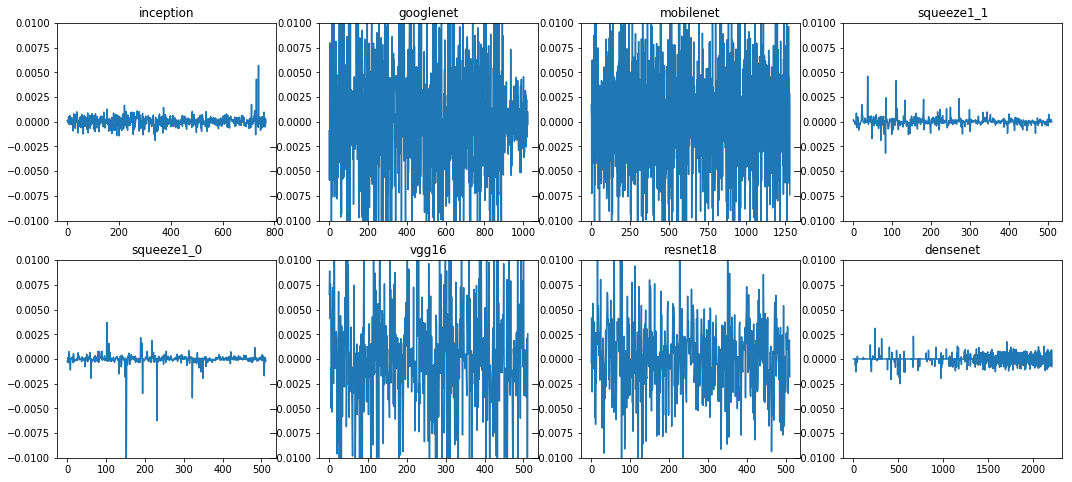

In [205]:
plt.figure(figsize=(18,8))
for n in range(EC1.n_models-1):
    plt.subplot(2,4,n+1)
    plt.plot(np.mean(np.mean(EC1.tensor_w[n][:,:,:,i].cpu().numpy(),axis=1),axis=1))
    plt.title(EC1.models[n]['id'])
    plt.ylim([-.01,.01])
plt.show()

In [174]:
ks = np.zeros((EC1.n_models,EC1.n_targets))
kn = np.zeros((EC1.n_models,EC1.n_targets))
kr = np.zeros((EC1.n_models,EC1.n_targets))
for n in range(EC1.n_models-1):
    for i in range(EC1.n_targets):
        ks[n,i] = np.linalg.norm(EC1.tensor_w[n][:,:,:,i].mean(axis=1).mean(axis=1).cpu().squeeze().numpy(),ord=1)
        kn[n,i] = np.linalg.norm(EC1.tensor_w[n][:,:,:,i].mean(axis=1).mean(axis=1).cpu().squeeze().numpy())
        kr[n,i] = np.max(EC1.tensor_w[n][:,:,:,i].mean(axis=1).mean(axis=1).cpu().squeeze().numpy())

ws = np.zeros((EC1.n_models,EC1.n_targets))
wn = np.zeros((EC1.n_models,EC1.n_targets))
wr = np.zeros((EC1.n_models,EC1.n_targets))
for n in range(EC1.n_models-1):
    for i in range(EC1.n_targets):
        ws[n,i] = torch.linalg.norm(EC1.tensor_w[n][:,:,:,i].flatten(),ord = 1).cpu().numpy()
        wn[n,i] = torch.linalg.norm(EC1.tensor_w[n][:,:,:,i].flatten()).cpu().numpy()
        wr[n,i] = np.max(EC1.tensor_w[n][:,:,:,i].cpu().squeeze().numpy())
        
acs = np.zeros((EC1.n_models,EC1.n_targets))
acn = np.zeros((EC1.n_models,EC1.n_targets))
acr = np.zeros((EC1.n_models,EC1.n_targets))
for n in range(EC1.n_models):
    nunits = EC1.models[n]['dim'].numel()
    sampu = np.random.choice(n_data,200)
    for i in range(200):
        tempdact = EC1.models[n]['activations'][sampu[i],:,:,:].flatten().numpy()
        acs[n,i] = np.linalg.norm(tempdact,ord = 1)
        acn[n,i] = np.linalg.norm(tempdact)
        acr[n,i] = np.max(tempdact)

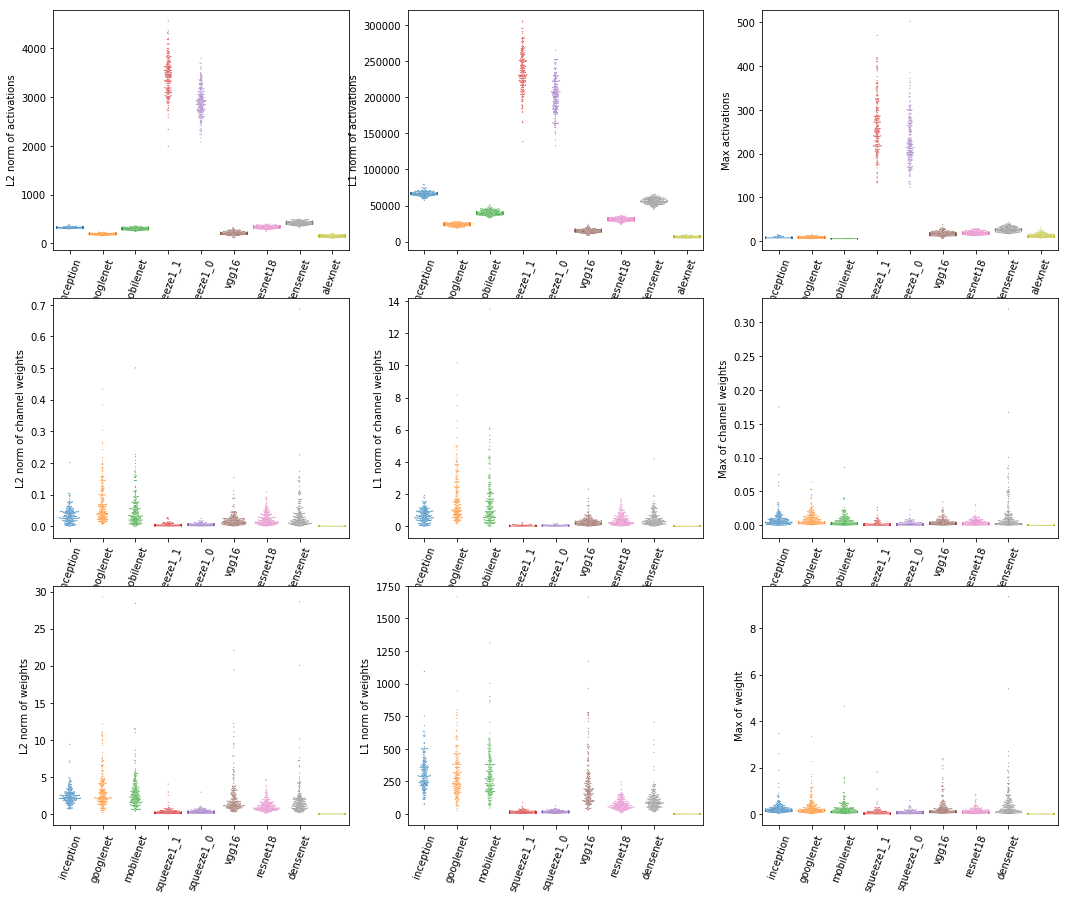

In [201]:
plt.figure(figsize=(18,15))
plt.subplot(3,3,1)
sns.swarmplot(data = acn.T,size = 1)
plt.xticks(np.arange(EC1.n_models),[EC1.models[n]['id'] for n in range(EC1.n_models)])
plt.xticks(rotation=70)
#plt.ylim([0,2000])
plt.ylabel('L2 norm of activations')

plt.subplot(3,3,2)
sns.swarmplot(data = acs.T,size = 1)
plt.xticks(np.arange(EC1.n_models),[EC1.models[n]['id'] for n in range(EC1.n_models)])
plt.xticks(rotation=70)
#plt.ylim([0,50000])
plt.ylabel('L1 norm of activations')

plt.subplot(3,3,3)
sns.swarmplot(data = acr.T,size = 1)
plt.xticks(np.arange(EC1.n_models),[EC1.models[n]['id'] for n in range(EC1.n_models)])
plt.xticks(rotation=70)
plt.ylabel('Max activations')

plt.subplot(3,3,4)
sns.swarmplot(data = kn.T,size = 1)
plt.xticks(np.arange(EC1.n_models-1),[EC1.models[n]['id'] for n in range(EC1.n_models-1)])
plt.xticks(rotation=70)
#plt.ylim([0,10])
plt.ylabel('L2 norm of channel weights')

plt.subplot(3,3,5)
sns.swarmplot(data = ks.T,size = 1)
plt.xticks(np.arange(EC1.n_models-1),[EC1.models[n]['id'] for n in range(EC1.n_models-1)])
plt.xticks(rotation=70)
#plt.ylim([0,500])
plt.ylabel('L1 norm of channel weights')

plt.subplot(3,3,6)
sns.swarmplot(data = kr.T,size = 1)
plt.xticks(np.arange(EC1.n_models-1),[EC1.models[n]['id'] for n in range(EC1.n_models-1)])
plt.xticks(rotation=70)
plt.ylabel('Max of channel weights')
#plt.ylim([0,1])

plt.subplot(3,3,7)
sns.swarmplot(data = wn.T,size = 1)
plt.xticks(np.arange(EC1.n_models-1),[EC1.models[n]['id'] for n in range(EC1.n_models-1)])
plt.xticks(rotation=70)
#plt.ylim([0,10])
plt.ylabel('L2 norm of weights')

plt.subplot(3,3,8)
sns.swarmplot(data = ws.T,size = 1)
plt.xticks(np.arange(EC1.n_models-1),[EC1.models[n]['id'] for n in range(EC1.n_models-1)])
plt.xticks(rotation=70)
#plt.ylim([0,500])
plt.ylabel('L1 norm of weights')

plt.subplot(3,3,9)
sns.swarmplot(data = wr.T,size = 1)
plt.xticks(np.arange(EC1.n_models-1),[EC1.models[n]['id'] for n in range(EC1.n_models-1)])
plt.xticks(rotation=70)
plt.ylabel('Max of weight')
#plt.ylim([0,1])
plt.show()

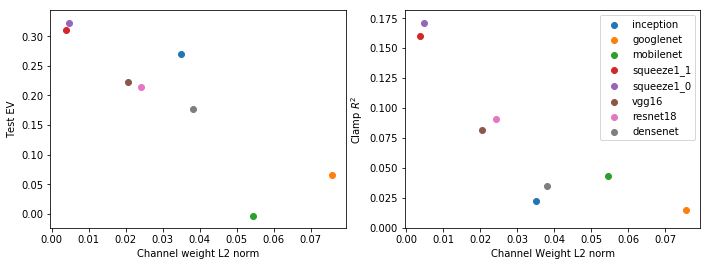

In [203]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
for n in range(EC1.n_models-1):
    plt.scatter(kn[n,:].mean(),EC1.models[n]['test_score'].mean())
#plt.xticks(rotation=70)
plt.xlabel('Channel weight L2 norm')
plt.ylabel('Test EV')

plt.subplot(1,3,2)
for n in range(EC1.n_models-1):
    plt.scatter(kn[n,:].mean(), (EC1.models[n]['ctr_p_score']**2).mean(),label = EC1.models[n]['id'])
#plt.xticks(rotation=70)
plt.legend()
plt.xlabel('Channel Weight L2 norm')
plt.ylabel(r'Clamp $R^2$')
plt.show()

In [200]:
acn[1].mean()

195.13415008544922

In [ ]:
# scalar A-clamp with indivisual models and with ensemble
EC1.design_scalar_clamp(hvmclampset, epsilon = 10, n_units = 2)
EC1.scalar_model_clamp(lr = .005, wd = 1e-3, n_iter = 20)
EC1.scalar_ensemble_clamp(lr = .005, wd = 1e-4, n_iter = 20)
#EC1.scalar_clamp_score()

In [ ]:
import seaborn as sns

gaussfit = lambda x,mu,sig: 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)
xdelta = .2
eps = 10
xbin = np.arange(-eps-2,eps+2,xdelta)
mad = lambda x: np.median(abs(x-np.median(x)))

samp_set = [0]
# show example of single neuron activity clamp
plt.figure(figsize=(18,5))
pidx = EC1.ensemble['sur_s_eps'][:,samp_set[0]]>0
nidx = EC1.ensemble['sur_s_eps'][:,samp_set[0]]<0
p_sur_obs = EC1.ensemble['sur_s_obs'].numpy()[pidx,samp_set[0]]
n_sur_obs = EC1.ensemble['sur_s_obs'].numpy()[nidx,samp_set[0]]
ax1 = plt.subplot(1,3,1)
sns.histplot(p_sur_obs,bins = xbin,color='b',label=r'$\epsilon = +10$')
sns.histplot(n_sur_obs,bins = xbin,color='r',label=r'$\epsilon = -10$')
plt.plot(xbin, gaussfit(xbin,np.median(n_sur_obs),mad(n_sur_obs))*len(p_sur_obs)*.2,'r-')
plt.plot(xbin, gaussfit(xbin,np.median(p_sur_obs),mad(p_sur_obs))*len(p_sur_obs)*.2,'b-')
plt.plot([0,0],[0,1000],'k--')
plt.ylim((0,n_clamp/5))
plt.xlabel(r'$\delta f^{\ surrogate}(x+\delta x)$',fontsize = 18)
plt.ylabel(r'# images',fontsize = 18)
plt.legend(fontsize = 18)

p_tar_obs = EC1.ensemble['tar_s_obs'].numpy()[pidx,samp_set[0]]
n_tar_obs = EC1.ensemble['tar_s_obs'].numpy()[nidx,samp_set[0]]
ax2 = plt.subplot(1,3,2)
xbin = np.arange(-eps*5,eps*5,1)
sns.histplot(p_tar_obs,bins = xbin,color='b',label=r'$\epsilon = +10$')
sns.histplot(n_tar_obs,bins = xbin,color='r',label=r'$\epsilon = -10$')
plt.plot(xbin, gaussfit(xbin,np.median(n_tar_obs[abs(n_tar_obs)>1e-5]),np.std(n_tar_obs[abs(n_tar_obs)>1e-5]))*sum(abs(p_tar_obs)>1e-5)*.2,'r-')
plt.plot(xbin, gaussfit(xbin,np.median(p_tar_obs[abs(p_tar_obs)>1e-5]),np.std(p_tar_obs[abs(p_tar_obs)>1e-5]))*sum(abs(p_tar_obs)>1e-5)*.2,'b-')
plt.plot([0,0],[0,1000],'k--')
plt.ylim((0,n_clamp/50))
#plt.xlim([-eps, eps])
plt.xlabel(r'$\delta f^{\ target}(x+\delta x)$',fontsize = 18)
plt.ylabel(r'# images',fontsize = 18)

p_dx = EC1.ensemble['s_dx'].numpy()[pidx,samp_set[0]]
n_dx = EC1.ensemble['s_dx'].numpy()[nidx,samp_set[0]]
ax1 = plt.subplot(1,3,3)
xbin = np.arange(0,eps*2,xdelta)
sns.histplot(p_dx,bins = xbin,color='b',label=r'$\epsilon = +10$')
sns.histplot(n_dx,bins = xbin,color='r',label=r'$\epsilon = -10$')
plt.plot(xbin, gaussfit(xbin,np.median(n_dx),mad(n_dx))*len(p_sur_obs)*.2,'r-')
plt.plot(xbin, gaussfit(xbin,np.median(p_dx),mad(p_dx))*len(p_sur_obs)*.2,'b-')
plt.plot([0,0],[0,1000],'k--')
plt.ylim((0,n_data/50))
plt.xlabel(r'$|\delta x|$',fontsize = 18)
plt.ylabel(r'# images',fontsize = 18)
plt.show()

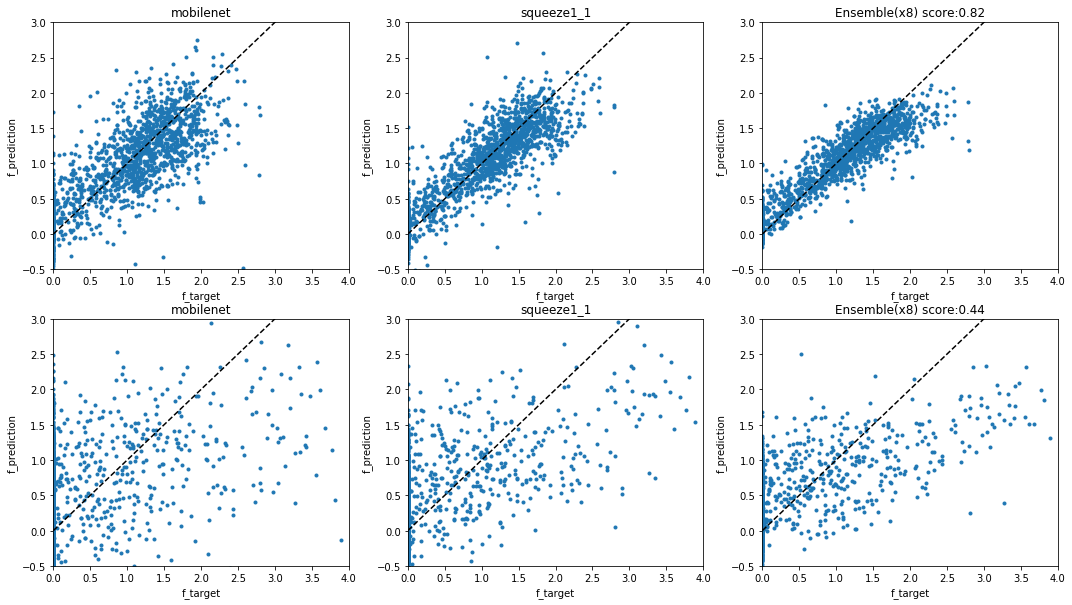

In [58]:
i = np.argmax(EC1.ensemble['test_score'][:,0,-1])
Y_train = EC1.models[-1]['activations'][EC1.indexer.get_tar(EC1.target_idx,EC1.test_idx)].detach()
Y_train_pred1 = EC1.models[2]['predictions'][EC1.test_idx,i]
Y_train_pred2 = EC1.models[3]['predictions'][EC1.test_idx,i]
Y_train_epred = EC1.ensemble['predictions'][EC1.test_idx,i,-1]

plt.figure(figsize=(18,10))
plt.subplot(2,3,1)
plt.plot(Y_train[:,i],Y_train_pred1,'.')
plt.plot([0,10],[0,10],'k--')
plt.xlim([0,4])
plt.ylim([-.5,3])
plt.title(EC1.models[2]['id'])
plt.xlabel('f_target')
plt.ylabel('f_prediction')
plt.subplot(2,3,2)
plt.plot(Y_train[:,i],Y_train_pred2,'.')
plt.plot([0,10],[0,10],'k--')
plt.xlim([0,4])
plt.ylim([-.5,3])
plt.title(EC1.models[3]['id'])
plt.xlabel('f_target')
plt.ylabel('f_prediction')
plt.subplot(2,3,3)
plt.plot(Y_train[:,i],Y_train_epred,'.')
plt.plot([0,10],[0,10],'k--')
plt.xlim([0,4])
plt.ylim([-.5,3])
bestscore = EC1.ensemble['test_score'][i,0,-1]
plt.title(f'Ensemble(x{EC1.n_models-1}) score:{bestscore:.2f}')
plt.xlabel('f_target')
plt.ylabel('f_prediction')


i = 2#np.argmin(EC1.ensemble['test_score'][:,0,-1])
Y_train = EC1.models[-1]['activations'][EC1.indexer.get_tar(EC1.target_idx,EC1.test_idx)].detach()
Y_train_pred1 = EC1.models[2]['predictions'][EC1.test_idx,i]
Y_train_pred2 = EC1.models[3]['predictions'][EC1.test_idx,i]
Y_train_epred = EC1.ensemble['predictions'][EC1.test_idx,i,-1]
plt.subplot(2,3,4)
plt.plot(Y_train[:,i],Y_train_pred1,'.')
plt.plot([0,10],[0,10],'k--')
plt.xlim([0,4])
plt.ylim([-.5,3])
plt.title(EC1.models[2]['id'])
plt.xlabel('f_target')
plt.ylabel('f_prediction')
plt.subplot(2,3,5)
plt.plot(Y_train[:,i],Y_train_pred2,'.')
plt.plot([0,10],[0,10],'k--')
plt.xlim([0,4])
plt.ylim([-.5,3])
plt.title(EC1.models[3]['id'])
plt.xlabel('f_target')
plt.ylabel('f_prediction')
plt.subplot(2,3,6)
plt.plot(Y_train[:,i],Y_train_epred,'.')
plt.plot([0,10],[0,10],'k--')
plt.xlim([0,4])
plt.ylim([-.5,3])
bestscore = EC1.ensemble['test_score'][i,0,-1]
plt.title(f'Ensemble(x{EC1.n_models-1}) score:{bestscore:.2f}')
plt.xlabel('f_target')
plt.ylabel('f_prediction')
plt.show()

In [5]:
# package as input to the controller
nets2 = [googlenet,mobilenet,squeezenet1,vgg16,resnet,alexnet, inception]
labels2 = ['googlenet','mobilenet','squeeze1_1','vgg16','resnet18','alexnet','inception']
layers2 = [16,19,13,30,8,13,11]
n_models2 = len(labels2)

# load dataset
n_data = 5000;
n_train = 4000;
n_test = 1000;
n_targets = 200;
hvmdataset = HVMDataset('cpu',n_data, shuffle = True)

# create ensemble controller
EC12 = EnsembleController(nets2,layers2,labels2,device)
EC12.design(hvmdataset, batch_size = 10)
EC12.train_test_subset(n_train,n_test,n_targets)
EC12.fit(option = 'TR',label = '_6nets_tar_inc', n_iter = 200, w_reg = 100)
EC12.score_models()
EC12.get_surrogate()
EC12.score_ensembles()

loading and preprocessing hvm


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:46<00:00, 106.79it/s]


Extracting activations


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:54<00:00, 15.18s/it]


MemoryError: 

In [ ]:
plt.figure(figsize=(18,5))
ax1 = plt.subplot(1,3,1)
for n in range(EC12.n_models-1):
    plt.scatter(EC12.models[n]['train_score'],EC12.models[n]['test_score'],label = EC12.models[n]['id'],alpha = .5,s=8)
plt.scatter(EC12.ensemble['train_score'][:,0,-1],EC12.ensemble['test_score'][:,0,-1],label=f'Ensemble(x{n_models2-1})',c='k',alpha = .8, s=8)
plt.plot([-1,1],[-1,1],'k--')
plt.xlabel('Train EV')
plt.ylabel('Test EV')
plt.title('Each dot is a target unit')
plt.legend()
plt.xlim([0,1])
plt.ylim([-.5,1])
ax2 = plt.subplot(1,3,2)
for n in range(EC12.n_models-1):
    plt.errorbar(np.mean(EC12.models[n]['train_score']), np.mean(EC12.models[n]['test_score']), xerr=np.std(EC12.models[n]['train_score']), yerr=np.std(EC12.models[n]['test_score']), fmt='o',capsize=4, label = EC12.models[n]['id'])
plt.errorbar(np.mean(EC12.ensemble['train_score'][:,0,-1],axis = 0),np.mean(EC12.ensemble['test_score'][:,0,-1],axis = 0), xerr=np.std(EC12.ensemble['train_score'][:,0,-1],axis = 0), yerr=np.std(EC12.ensemble['test_score'][:,0,-1],axis = 0), fmt='ko-',capsize=4,label=f'Ensemble(x{n_models2-1})')
plt.plot([-1,1],[-1,1],'k--')
plt.title('Average over all target units')
plt.xlabel('Train EV')
plt.ylabel('Test EV')
plt.legend()
plt.xlim([0,1])
plt.ylim([-.5,1])
ax2 = plt.subplot(1,3,3)
plt.errorbar(np.mean(np.mean(EC12.ensemble['train_score'][:,:,[0,1,3,-1]],axis = 0),axis=0),np.mean(np.mean(EC12.ensemble['test_score'][:,:,[0,1,3,-1]],axis = 0),axis=0), xerr=np.mean(np.std(EC12.ensemble['train_score'][:,:,[0,1,3,-1]],axis = 0),axis = 0), yerr=np.mean(np.std(EC12.ensemble['test_score'][:,:,[0,1,3,-1]],axis = 0),axis=0), fmt='ko-',capsize=4,label=f'Ensemble(x{n_models2-1})')
plt.plot([-1,1],[-1,1],'k--')
plt.title('Average over all target units')
plt.xlabel('Train EV')
plt.ylabel('Test EV')
plt.legend()
plt.xlim([0,1])
plt.ylim([-.5,1])
plt.show()

In [ ]:
n_clamp = 500;
hvmclampset = HVMDataset('cpu', n_data, n_train, n_test, n_clamp, shuffle = True, subset = 'clamp')
# projected A-clamp with indivisual models and with ensemble
EC12.design_proj_clamp(hvmclampset, epsilon = 10, n_sets = 20, set_size = 40)
EC1.proj_ensemble_clamp(hvmclampset, lr = .01, wd = 1e-3, n_iter = 10, batch_size = 2)
EC12.proj_model_clamp(lr = .01, wd = 1e-3, n_iter = 10)
EC12.proj_clamp_score()

In [ ]:
plt.figure(figsize=(18,5))
ax1 = plt.subplot(1,3,1)
for n in range(EC12.n_models-1):
    set_test_score = np.zeros(EC12.n_sets)
    for s in range(EC12.n_sets):
        set_test_score[s] = EC12.models[n]['test_score'][EC12.clamp_set_i[:,s]].mean()
    plt.scatter(set_test_score,EC12.models[n]['ctr_p_score']**2,label = EC12.models[n]['id'],s=8)
set_test_escore = np.zeros(EC12.n_sets)
for s in range(EC12.n_sets):
    set_test_escore[s] = EC12.ensemble['test_score'][EC12.clamp_set_i[:,s]].mean()    
plt.scatter(set_test_escore,EC12.ensemble['ctr_p_score']**2,label=f'Ensemble(x{n_models2-1})',c='k',s=8)
plt.plot([-1,1],[-1,1],'k--')
plt.xlabel('Test EV')
plt.ylabel(r'Clamp $R^2$')
plt.title('Each dot is a set')
plt.legend()
plt.xlim([-.5,.25])
plt.ylim([-.1, .5])

ax2 = plt.subplot(1,3,2)
for n in range(EC12.n_models-1):
    set_test_score = np.zeros(EC12.n_sets)
    for s in range(EC12.n_sets):
        set_test_score[s] = EC12.models[n]['test_score'][EC12.clamp_set_i[:,s]].mean()
    plt.errorbar(np.mean(set_test_score), np.mean(EC12.models[n]['ctr_p_score']**2), xerr=np.std(set_test_score), yerr=np.std(EC12.models[n]['ctr_p_score']**2), fmt='o',capsize=4, label = EC12.models[n]['id'])
plt.errorbar(np.mean(set_test_escore,axis = 0), np.mean(EC12.ensemble['ctr_p_score']**2,axis = 0), xerr=np.std(set_test_escore,axis = 0), yerr=np.std(EC12.ensemble['ctr_p_score']**2,axis = 0), fmt='ko-',capsize=4,label=f'Ensemble(x{n_models2-1})')
plt.plot([-1,1],[-1,1],'k--')
plt.title('Average over all sets')
plt.xlabel('Test EV')
plt.ylabel(r'Clamp $R^2$')
plt.legend()
plt.xlim([-.5,.25])
plt.ylim([-.1, .5])
plt.show()

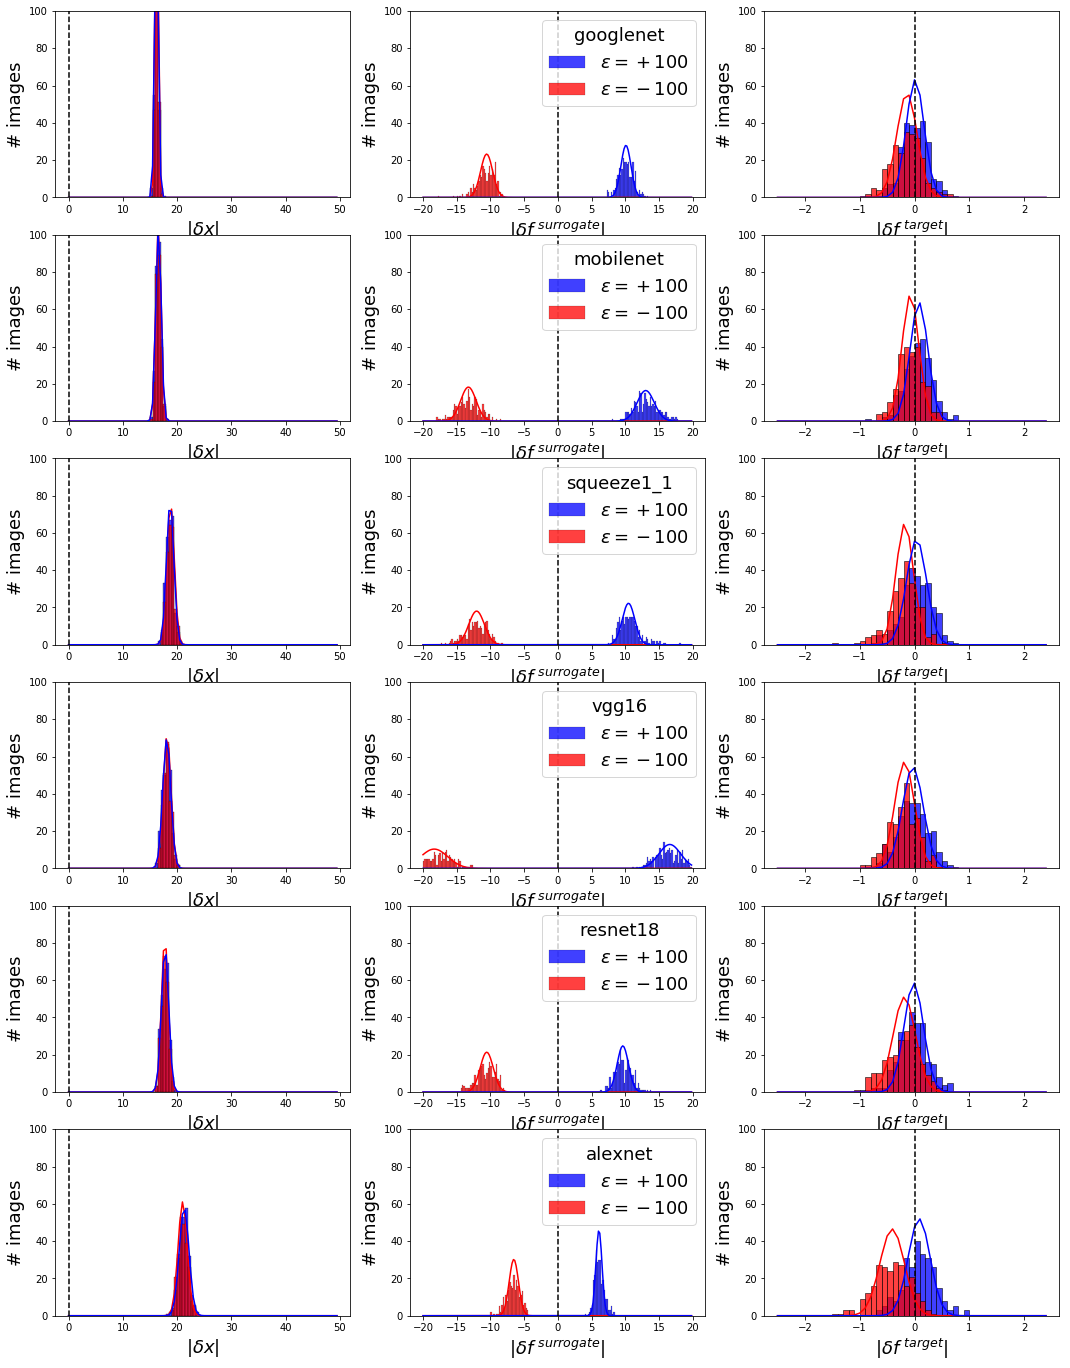

In [28]:
import seaborn as sns

gaussfit = lambda x,mu,sig: 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)
eps = 10
mad = lambda x: np.median(abs(x-np.median(x)))

samp_set = [4]
plt.figure(figsize=(18,4*(EC12.n_models-1)))
for n in range(EC12.n_models-1):
    # show example of single neuron activity clamp
    pidx = EC12.models[n]['sur_p_eps'][:,samp_set[0]]>0
    nidx = EC12.models[n]['sur_p_eps'][:,samp_set[0]]<0
    p_sur_obs = EC12.models[n]['sur_p_obs'].numpy()[pidx,samp_set[0]]
    n_sur_obs = EC12.models[n]['sur_p_obs'].numpy()[nidx,samp_set[0]]
    plt.subplot(EC12.n_models-1,3,2+n*3)
    xdelta = .2
    xbin = np.arange(-eps*2,eps*2,xdelta)
    sns.histplot(p_sur_obs,bins = xbin,color='b',label=r'$\epsilon = +100$')
    sns.histplot(n_sur_obs,bins = xbin,color='r',label=r'$\epsilon = -100$')
    plt.plot(xbin, gaussfit(xbin,np.median(n_sur_obs),mad(n_sur_obs))*len(p_sur_obs)*xdelta,'r-')
    plt.plot(xbin, gaussfit(xbin,np.median(p_sur_obs),mad(p_sur_obs))*len(p_sur_obs)*xdelta,'b-')
    plt.plot([0,0],[0,1000],'k--')
    plt.ylim((0,n_clamp/5))
    plt.xlabel(r'$|\delta f^{\ surrogate}|$',fontsize = 18)
    plt.ylabel(r'# images',fontsize = 18)
    legend = plt.legend(fontsize = 18, title=EC12.models[n]['id'])
    legend.get_title().set_fontsize('18')
    
    p_tar_obs = EC12.models[n]['tar_p_obs'].numpy()[pidx,samp_set[0]]
    n_tar_obs = EC12.models[n]['tar_p_obs'].numpy()[nidx,samp_set[0]]
    plt.subplot(EC12.n_models-1,3,3+n*3)
    xdelta3 = .1
    xbin3 = np.arange(-eps/4,eps/4,xdelta3)
    sns.histplot(p_tar_obs,bins = xbin3,color='b',label=r'$\epsilon = +100$')
    sns.histplot(n_tar_obs,bins = xbin3,color='r',label=r'$\epsilon = -100$')
    plt.plot(xbin3, gaussfit(xbin3,np.median(n_tar_obs),mad(n_tar_obs))*len(p_sur_obs)*xdelta3,'r-')
    plt.plot(xbin3, gaussfit(xbin3,np.median(p_tar_obs),mad(p_tar_obs))*len(p_sur_obs)*xdelta3,'b-')
    plt.plot([0,0],[0,1000],'k--')
    plt.ylim((0,n_clamp/5))
    plt.xlabel(r'$|\delta f^{\ target}|$',fontsize = 18)
    plt.ylabel(r'# images',fontsize = 18)

    p_dx = EC12.models[n]['p_dx'].numpy()[pidx,samp_set[0]]
    n_dx = EC12.models[n]['p_dx'].numpy()[nidx,samp_set[0]]
    plt.subplot(EC12.n_models-1,3,1+n*3)
    xdelta1 = .5
    xbin1 = np.arange(0,eps*5,xdelta1)
    sns.histplot(p_dx,bins = xbin1,color='b',label=r'$\epsilon = +100$')
    sns.histplot(n_dx,bins = xbin1,color='r',label=r'$\epsilon = -100$')
    plt.plot(xbin1, gaussfit(xbin1,np.median(n_dx),np.std(n_dx))*len(p_sur_obs)*xdelta1,'r-')
    plt.plot(xbin1, gaussfit(xbin1,np.median(p_dx),np.std(p_dx))*len(p_sur_obs)*xdelta1,'b-')
    plt.plot([0,0],[0,1000],'k--')
    plt.ylim((0,n_data/50))
    plt.xlabel(r'$|\delta x|$',fontsize = 18)
    plt.ylabel(r'# images',fontsize = 18)
plt.show()

In [109]:
ws = np.zeros((EC12.n_models,EC12.n_targets))
wn = np.zeros((EC12.n_models,EC12.n_targets))
wr = np.zeros((EC12.n_models,EC12.n_targets))
for n in range(EC12.n_models-1):
    for i in range(EC12.n_targets):
        ws[n,i] = np.linalg.norm(EC12.tensor_w[n][:,:,:,i].reshape((-1,1)).cpu().squeeze().numpy(),ord=1)
        wn[n,i] = np.linalg.norm(EC12.tensor_w[n][:,:,:,i].reshape((-1,1)).cpu().squeeze().numpy())
        wr[n,i] = np.max(EC12.tensor_w[n][:,:,:,i].reshape((-1,1)).cpu().squeeze().numpy())

acs = np.zeros((EC12.n_models,EC12.n_targets))
acn = np.zeros((EC12.n_models,EC12.n_targets))
acr = np.zeros((EC12.n_models,EC12.n_targets))
for n in range(EC12.n_models):
    nunits = EC12.models[n]['dim'].numel()
    sampu = np.random.choice(nunits,200)
    for i in range(200):
        tempdact = EC12.models[n]['activations'].reshape((n_data,-1))[:,sampu[i]].numpy()
        acs[n,i] = np.linalg.norm(tempdact,ord = 1)
        acn[n,i] = np.linalg.norm(tempdact)
        acr[n,i] = np.max(tempdact)

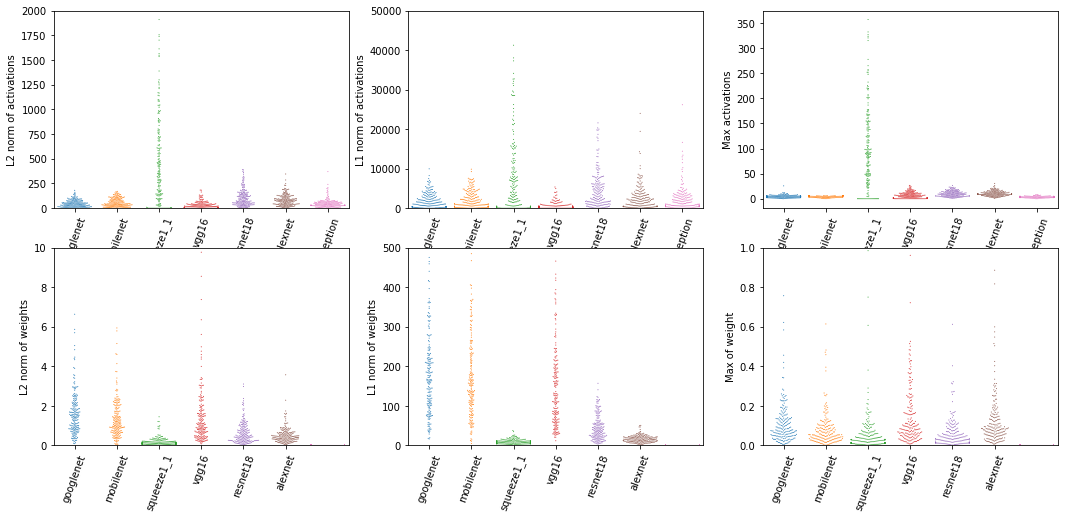

In [126]:
plt.figure(figsize=(18,8))
plt.subplot(2,3,1)
sns.swarmplot(data = acn.T,size = 1)
plt.xticks(np.arange(EC12.n_models),[EC12.models[n]['id'] for n in range(EC12.n_models)])
plt.xticks(rotation=70)
plt.ylim([0,2000])
plt.ylabel('L2 norm of activations')

plt.subplot(2,3,2)
sns.swarmplot(data = acs.T,size = 1)
plt.xticks(np.arange(EC12.n_models),[EC12.models[n]['id'] for n in range(EC12.n_models)])
plt.xticks(rotation=70)
plt.ylim([0,50000])
plt.ylabel('L1 norm of activations')

plt.subplot(2,3,3)
sns.swarmplot(data = acr.T,size = 1)
plt.xticks(np.arange(EC12.n_models),[EC12.models[n]['id'] for n in range(EC12.n_models)])
plt.xticks(rotation=70)
plt.ylabel('Max activations')

plt.subplot(2,3,4)
sns.swarmplot(data = wn.T,size = 1)
plt.xticks(np.arange(EC12.n_models-1),[EC12.models[n]['id'] for n in range(EC12.n_models-1)])
plt.xticks(rotation=70)
plt.ylim([0,10])
plt.ylabel('L2 norm of weights')

plt.subplot(2,3,5)
sns.swarmplot(data = ws.T,size = 1)
plt.xticks(np.arange(EC12.n_models-1),[EC12.models[n]['id'] for n in range(EC12.n_models-1)])
plt.xticks(rotation=70)
plt.ylim([0,500])
plt.ylabel('L1 norm of weights')

plt.subplot(2,3,6)
sns.swarmplot(data = wr.T,size = 1)
plt.xticks(np.arange(EC12.n_models-1),[EC12.models[n]['id'] for n in range(EC12.n_models-1)])
plt.xticks(rotation=70)
plt.ylabel('Max of weight')
plt.ylim([0,1])
plt.show()

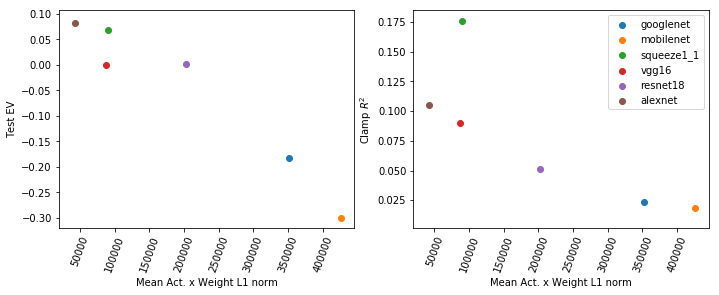

In [130]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
for n in range(EC12.n_models-1):
    plt.scatter(np.mean(acs[n,:]*ws[n,:]),np.median(EC12.models[n]['test_score']))
plt.xticks(rotation=70)
plt.xlabel('Mean Act. x Weight L1 norm')
plt.ylabel('Test EV')

plt.subplot(1,3,2)
for n in range(EC12.n_models-1):
    plt.scatter(np.mean(acs[n,:]*ws[n,:]), np.median(EC12.models[n]['ctr_p_score']**2),label = EC12.models[n]['id'])
plt.legend()
plt.xticks(rotation=70)
plt.xlabel('Mean Act. x Weight L1 norm')
plt.ylabel(r'Clamp $R^2$')
plt.show()

In [88]:
sampu

array([ 3074,  7566,  6659,  9830,  6641, 11542,   297,  3718,  3948,
       10142,  3816,  3727,   582,  3435,  5303,  3481,  9097,  9667,
        8300,  2140,  9969,  4602,  8525, 12051, 10718,  6598,  6561,
        7774, 11109,  9911, 11437,  3796,  5101,  8271,  6922,  3566,
        1148, 10103,  2763,   357, 10568,  7499,  6179, 11952,  9282,
        8627,  5505,  7068,  9824,  9676,  4413, 10944,  3300,  2521,
        6842,  8006, 10891,  1731,  6047,  6249,   293,  9543,    66,
        3037,  6622,  4270,  5502,  2660,  6148,  6933,  1047,  4688,
        3006,  4301,  7775,  9244,  3735,  7779,  8654,  5723, 10990,
        3871,  6156, 11621,  8785,  8945,  4619, 12465,   494,  7003,
        9264,  1257,  4047,  8732,  2224, 11326,  3488,  7521,  4297,
        6248, 10275,  7056,  6274,  9017,  4265,  8360,  4364,  2759,
        2140,  4944,  3820, 11811,  1341,  4388,  2711,  1343,   944,
         583,  6367,  8106,  3019,  3578, 11837, 11478,  1552,  4519,
        2959,   620,